https://towardsdatascience.com/satellite-imagery-analysis-using-python-9f389569862c

gdal_translate T33SVV_20210208T094049_B12.jp2 B12.tif

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from skimage import exposure
from rasterio import plot
import rasterio as rio
import geopandas as gpd #for charting and mapping
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# import bands as separate 1 band raster
#imagePath = './data/2015\S2A_MSIL1C_20150715T094306_N0204_R036_T33SVV_20150715T094315.SAFE\GRANULE\L1C_T33SVV_A000319_20150715T094315\IMG_DATA/'
#imagePath = './data/2017\S2A_MSIL1C_20171025T095101_N0206_R079_T33SVV_20171025T134153.SAFE\GRANULE\L1C_T33SVV_A012231_20171025T095911\IMG_DATA/'
#imagePath = './data/2018\S2A_MSIL1C_20180423T095031_N0206_R079_T33SVV_20180423T115454.SAFE\GRANULE\L1C_T33SVV_A014805_20180423T100033\IMG_DATA/'
#imagePath = './data/2019\S2A_MSIL1C_20190428T095031_N0207_R079_T33SVV_20190428T115403.SAFE\GRANULE\L1C_T33SVV_A020096_20190428T095033\IMG_DATA/'
#imagePath = './data/2020\S2A_MSIL1C_20200628T094041_N0209_R036_T33SVV_20200628T105543.SAFE\GRANULE\L1C_T33SVV_A026202_20200628T094036\IMG_DATA/'
#imagePath = './data/2021\S2B_MSIL1C_20210208T094049_N0209_R036_T33SVV_20210208T115143.SAFE\GRANULE\L1C_T33SVV_A020511_20210208T095028\IMG_DATA/'
#imagePath = './data/2020\S2B_MSIL1C_20200812T094039_N0209_R036_T33SVV_20200812T111443.SAFE\GRANULE\L1C_T33SVV_A017937_20200812T094034\IMG_DATA/'

#imagePath = './data/2020-2021 Winter\S2A_MSIL2A_20210414T094031_N0300_R036_T33SVV_20210414T123112.SAFE\GRANULE\L2A_T33SVV_A030349_20210414T094340\IMG_DATA\R20m/'
#imagePath = './data/2020-2021 Winter\S2B_MSIL2A_20201230T094319_N0214_R036_T33SVV_20201230T114149.SAFE\GRANULE\L2A_T33SVV_A019939_20201230T094317\IMG_DATA\R20m/'
#imagePath = '.\data/2020-2021 Winter\S2B_MSIL2A_20200105T094309_N0213_R036_T33SVV_20200105T111356.SAFE\GRANULE\L2A_T33SVV_A014791_20200105T095015\IMG_DATA\R20m/'

In [5]:
#New Data
#imagePath = '.\data/2015\S2A_MSIL1C_20151112T094232_N0204_R036_T33SVV_20151112T094226.SAFE\GRANULE\L1C_T33SVV_A002035_20151112T094226\IMG_DATA/'
imagePath = '.\data/2016\S2A_MSIL1C_20160321T094012_N0201_R036_T33SVV_20160321T094911.SAFE\GRANULE\L1C_T33SVV_A003894_20160321T094911\IMG_DATA/'
#imagePath = '.\data\2017\S2A_MSIL1C_20170309T095021_N0204_R079_T33SVV_20170309T095021.SAFE\GRANULE\L1C_T33SVV_A008942_20170309T095021\IMG_DATA/'
#imagePath = '.\data\2018\S2A_MSIL2A_20181030T095121_N0209_R079_T33SVV_20181030T135511.SAFE\GRANULE\L2A_T33SVV_A017522_20181030T095351\IMG_DATA\R20m/'

In [2]:
# Load polygon vector of AI (e.g.Gozo) to clip satellite image
boundsdata = r'./data/scale3.geojson'
region = gpd.read_file(boundsdata)
print(region)
nReserve_proj = region.to_crs({'init': 'epsg:32633'})

   id                                           geometry
0   1  MULTIPOLYGON (((14.43519 35.95796, 14.40944 35...


C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



----
Short-Wave Infrared (B12, B8A, B4)
--
The short-wave infrared band combination uses SWIR (B12), NIR (B8A), and red (B4). This composite shows vegetation
in various shades of green. In general, darker shades of green indicate denser vegetation. But brown is indicative of
bare soil and built-up areas.

https://osgis.org/2020/06/sentinel-2-bands-and-combinations/

https://towardsdatascience.com/satellite-imagery-analysis-using-python-9f389569862c
https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b

----

In [3]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return (array - array_min)/(array_max - array_min)

Step 1

In [4]:
#15
#T33SVV_20150715T094306_B01

#16x
#T33SVV_20150715T094306_B01

#17
#T33SVV_20171025T095101_B01

#18
#T33SVV_20180423T095031_B01

#19
#T33SVV_20190428T095031_B01

#20Jan x
#T33SVV_20200105T094309_B02_20m

#20Dec x
#T33SVV_20201230T094319_B03_20m

#21Apr x
#T33SVV_20210414T094031_B02_20m

#20 2a
#T33SVV_20200628T094041_B01

#20 2b
#T33SVV_20200812T094039_B01

#21
#B01

In [ ]:
#New Data
#15 Nov
#T33SVV_20151112T094232_B01

#16 Mar
#T33SVV_20160321T094012_B01

#17 Mar
#T33SVV_20170309T095021_B01

#18 Mar
#T33SVV_20181030T095121_B02_20m

In [8]:
b4 = rio.open(imagePath+'T33SVV_20160321T094012_B04.jp2')
b8a = rio.open(imagePath+'T33SVV_20160321T094012_B8A.jp2')
b12 = rio.open(imagePath+'T33SVV_20160321T094012_B12.jp2')

#export false color image
falseColor = rio.open('./Output/ShortWave.tiff', 'w', driver='Gtiff',
                          width=b4.width, height=b4.height,
                          count=3,
                          crs=b4.crs,
                          transform=b4.transform,
                          dtype='uint16'
                         )
falseColor.write(b12.read(1),1) #swir
falseColor.write(b8a.read(1),2) #vre
falseColor.write(b4.read(1),3) #red

falseColor.close()

Step 2
___

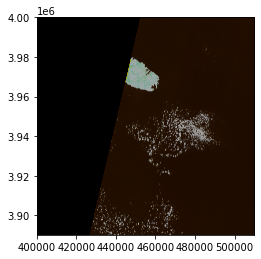

In [9]:
# Plot an intensity rescaled the ShortWave image with Rasterio

img = rio.open(r"./Output/ShortWave.tiff", count=3)

# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

plot.show(image.transpose(2,0,1), transform=img.transform)

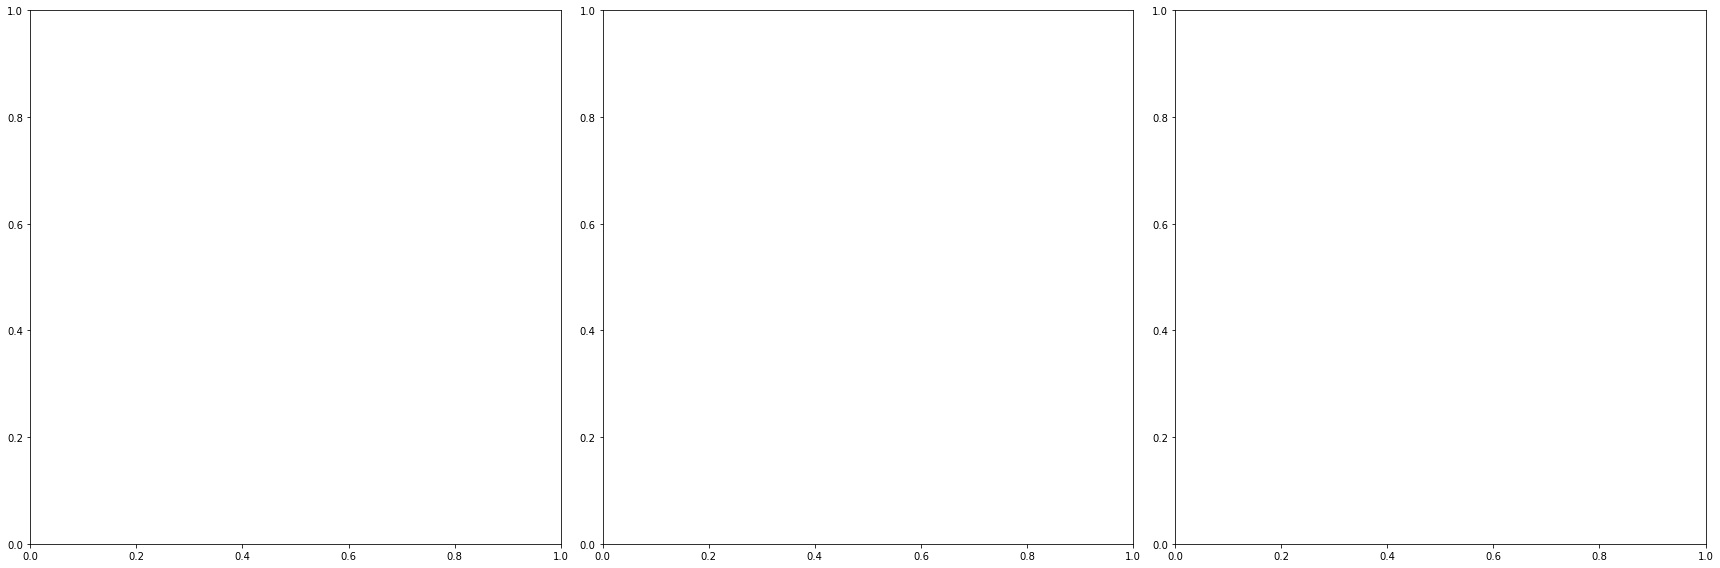

In [10]:
#multiple band representation

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
#plot.show(image[:,:,2], ax=ax1, cmap='Blues')
#plot.show(image[:,:,1], ax=ax2, cmap='Greens')
#plot.show(image[:,:,0], ax=ax3, cmap='Reds')
fig.tight_layout()


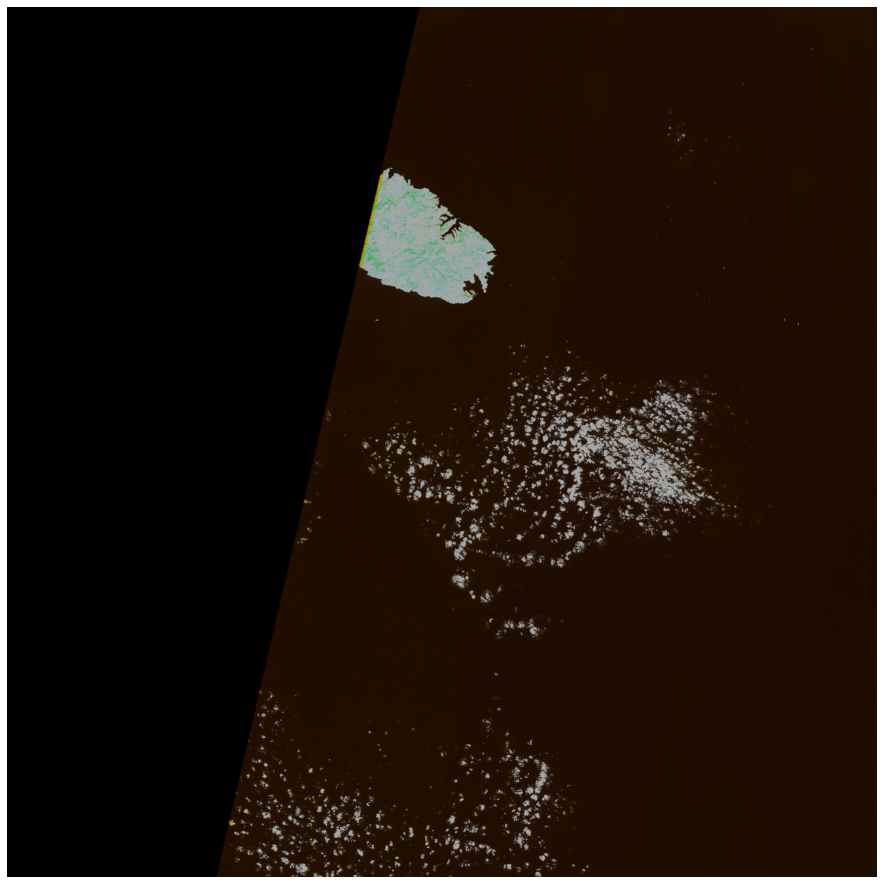

In [11]:
#Plot and save image with Matplotlib
fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(image)

#Save scaled reflectance image
# Call 'savefig' to save this plot to an image file
plt.savefig("./Output/Sentinel_Scaled_Reflectance.tiff", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [12]:
with rio.open("./Output/ShortWave.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "dtype": "uint16"})



with rio.open("./Output/RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

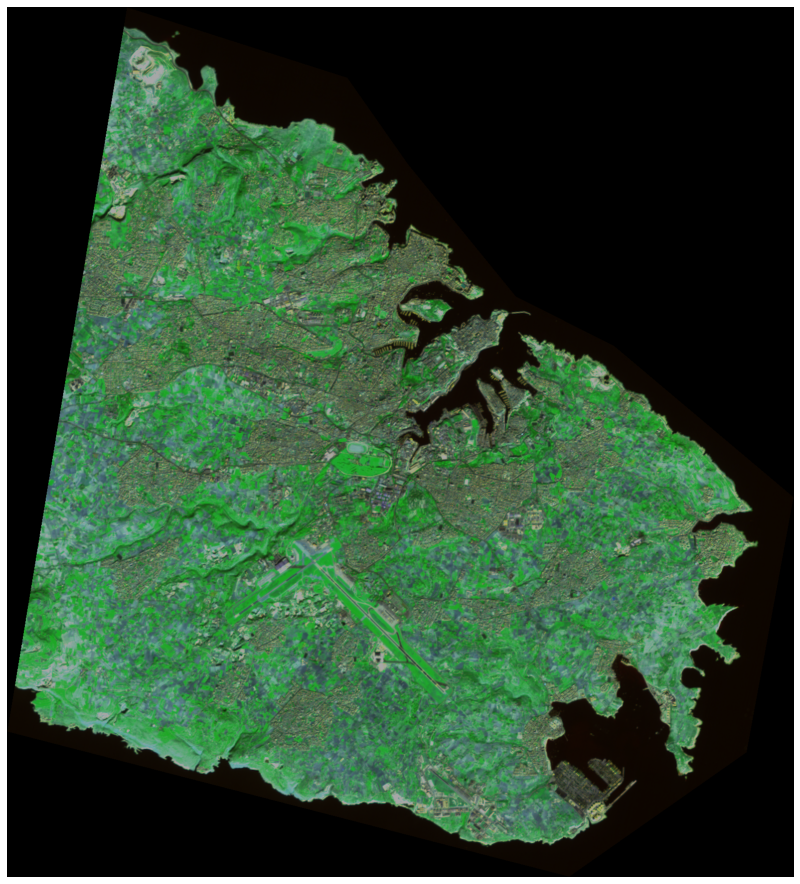

In [13]:
# Rescale the image (divide by 10000 to convert to [0:1] reflectance
image = np.array(out_image[[2,1,0], :, :])
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

rgb = np.array(image.transpose(1,2,0))

#Plot and save image with Matplotlib
fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plt.imshow(rgb)

#Save scaled reflectance image
# Call 'savefig' to save this plot to an image file
plt.savefig("./Output/Processed/ShortWave.png", bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

end
----



----
https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

https://eijournal.com/print/articles/how-to-interpret-a-false-color-satellite-image

----

C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


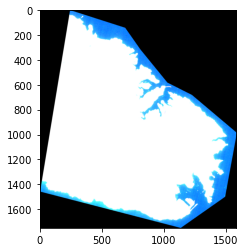

Min SWIR: 0
Max SWIR: 16169


In [13]:
# Crop NDVI to ROI
nReserve_proj = region.to_crs({'init': 'epsg:32633'})
with rio.open("./Output/RGB_masked.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('./Output/SWIR_cropped.tif', 'w', **out_meta) as dst:
    dst.write(out_image)
plot.show(out_image, cmap='plasma_r') ########################################
#gist_earth
#terrain
#cubehelix

#Print SWIR min and max
print('Min SWIR:', np.nanmin(out_image))
print('Max SWIR:', np.nanmax(out_image))

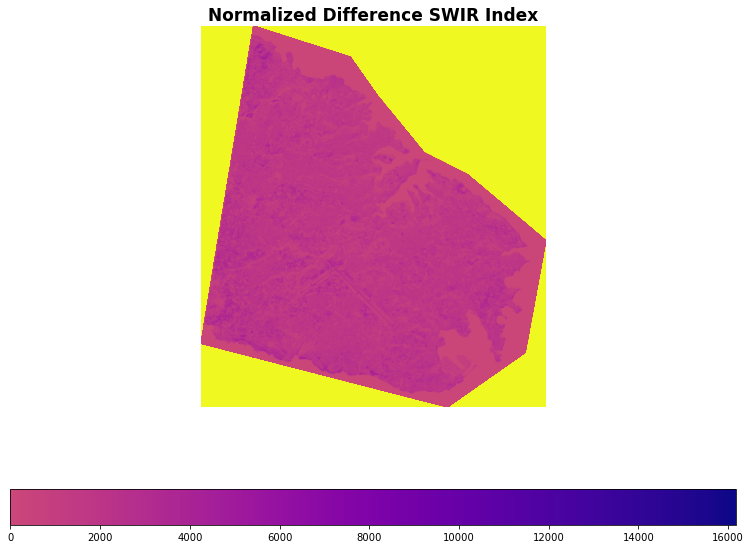

In [14]:
# Interpretation of mIndex


from matplotlib import colors


class MidpointNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):

        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Set min/max values from NDVI range for image

min=np.nanmin(out_image)
max=np.nanmax(out_image)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.plasma_r ####################################################
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

mIndex_cropped = rio.open("./Output/swir_cropped.tif")
# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(mIndex_cropped.read(1), cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels
ax.axis('off')

# Set a title
ax.set_title('Normalized Difference SWIR Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("./Output/swir-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

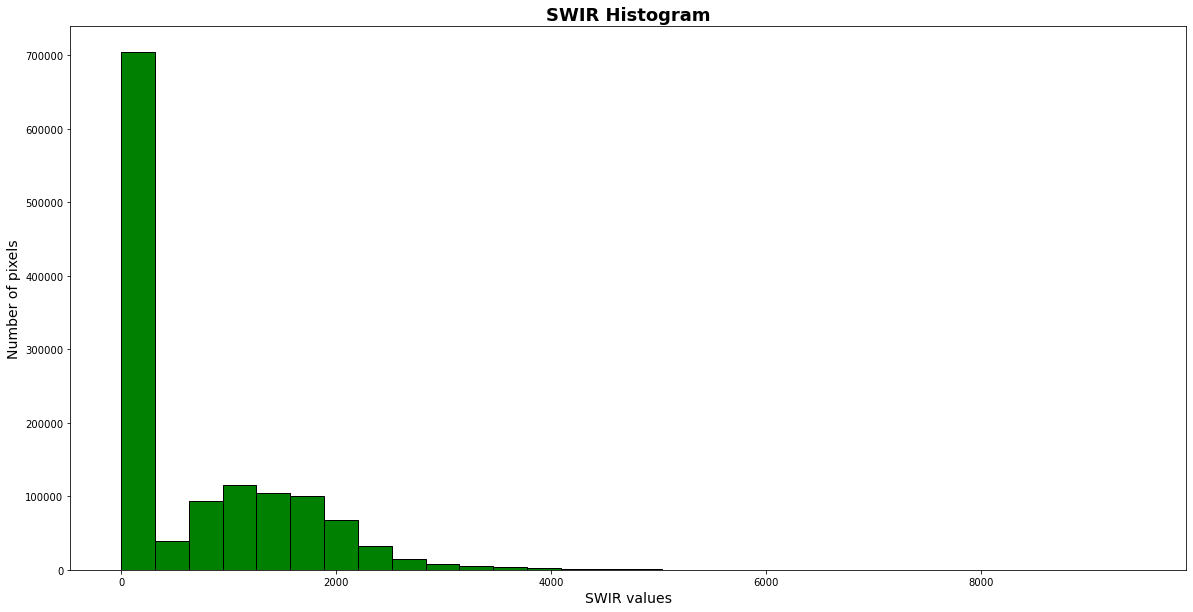

In [11]:
# Generate histogram of NDVI

# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("SWIR Histogram", fontsize=18, fontweight='bold')
plt.xlabel("SWIR values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = mIndex_cropped.read(1)[~np.isnan(mIndex_cropped.read(1))]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
fig2.savefig("./Output/Swir-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()
